# Polymarket Bot Detection

Per-wallet scoring + Isolation Forest to detect bots in Polymarket prediction markets.
Auto-fetches trade data via Polymarket API with parquet caching.

In [5]:
import time
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from utils import (
    FEATURE_COLS,
    build_group_features,
    compute_bot_score,
    run_isolation_forest,
)

from dr_manhattan.exchanges import Polymarket

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

MIN_TRADES = 5
MAX_MARKETS = 50
CACHE_DIR = Path('data/polymarket-snapshot/bot_research/')

GROUPS = {
    'btc_5m': {
        'label': 'BTC 5-min', 'tag_slug': '5M',
        'keywords': ['bitcoin', 'up or down'],
    },
    'btc_15m': {
        'label': 'BTC 15-min', 'tag_slug': '15M',
        'keywords': ['bitcoin', 'up or down'],
    },
    'btc_1h': {
        'label': 'BTC 1-hour', 'tag_slug': '1H',
        'keywords': ['bitcoin', 'up or down'],
    },
    'btc_4h': {
        'label': 'BTC 4-hour', 'tag_slug': '4h',
        'keywords': ['bitcoin', 'up or down'],
    },
    'btc_1d': {
        'label': 'BTC Daily', 'tag_slug': 'daily',
        'keywords': ['bitcoin', 'up or down'],
    },
    'epl_winner': {
        'label': 'EPL Winner', 'tag_slug': 'EPL',
        'keywords': ['wins the Premier League?'], 'limit': 20000,
    },
    'fed_january': {
        'label': 'Fed Rates Jan', 'tag_slug': 'fed-rates',
        'keywords': ['after january 2026 meeting'],
    },
    'trump_election': {
        'label': 'Trump 2024', 'tag_slug': 'us-presidential-election',
        'keywords': ['Will Donald Trump win the 2024 US Presidential Election?'], 'limit': 1000,
    },
    'tiktok_banned': {
        'label': 'TikTok Ban', 'tag_slug': 'tech',
        'keywords': ['TikTok banned in the US before May 2025?'], 'limit': 10000,
    },
}
GROUP_LABELS = {k: v['label'] for k, v in GROUPS.items()}

pm = Polymarket()


def fetch_all_trades(markets, group_name, limit=3000):
    """Fetch trades for all markets with parquet caching."""
    combined_path = CACHE_DIR / 'trades' / f'{group_name}_combined.parquet'

    if combined_path.exists():
        df = pd.read_parquet(combined_path)
        n_w = df['proxy_wallet'].nunique()
        print(f'  => combined cache: {len(df):,} trades, {n_w:,} wallets')
        return df

    cache_dir = CACHE_DIR / 'trades' / group_name
    cache_dir.mkdir(parents=True, exist_ok=True)
    parts = []
    for i, m in enumerate(markets):
        cid = m.metadata.get('conditionId', str(m.id))
        cache_path = cache_dir / f'{cid}.parquet'
        if cache_path.exists():
            df = pd.read_parquet(cache_path)
            print(f'  [{i+1}/{len(markets)}] cache: {cid[:12]}... ({len(df)})')
        else:
            try:
                df = pm.fetch_public_trades(
                    market=cid, limit=limit,
                    taker_only=True, as_dataframe=True,
                )
                if isinstance(df, list):
                    df = pd.DataFrame()
                if len(df) > 0:
                    df.to_parquet(cache_path)
                print(f'  [{i+1}/{len(markets)}] fetch: {cid[:12]}... ({len(df)})')
            except Exception as e:
                print(f'  [{i+1}/{len(markets)}] ERROR: {e}')
                df = pd.DataFrame()
            time.sleep(0.5)
        if len(df) > 0:
            parts.append(df)

    result = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    n_w = result['proxy_wallet'].nunique() if len(result) > 0 else 0
    print(f'  => {len(result):,} trades, {n_w:,} wallets')

    if len(result) > 0:
        combined_path.parent.mkdir(parents=True, exist_ok=True)
        result.to_parquet(combined_path)

    return result


print('setup OK')

setup OK


## 1. Load Data (auto-fetch + cache)

In [6]:
group_trades = {}
group_features = {}

for gname, cfg in GROUPS.items():
    combined_path = CACHE_DIR / 'trades' / f'{gname}_combined.parquet'

    if combined_path.exists():
        tdf = pd.read_parquet(combined_path)
        n_w = tdf['proxy_wallet'].nunique()
        print(f'[{cfg["label"]}] cache hit: {len(tdf):,} trades, {n_w:,} wallets')
    else:
        print(f'[{cfg["label"]}] no cache — fetching from API...')
        tag = pm.get_tag_by_slug(cfg['tag_slug'])
        api_limit = cfg.get('limit', 200)
        markets = pm.search_markets(
            tag_id=tag.id, closed=True, keywords=cfg['keywords'], limit=api_limit,
        )
        markets = markets[:MAX_MARKETS]
        print(f'  found {len(markets)} markets (capped to {MAX_MARKETS})')
        tdf = fetch_all_trades(markets, gname)

    if len(tdf) == 0:
        print(f'[{cfg["label"]}] no trades, skipping')
        continue

    group_trades[gname] = tdf
    fdf = build_group_features(tdf, min_trades=MIN_TRADES)
    group_features[gname] = fdf

    n_w = tdf['proxy_wallet'].nunique()
    print(
        f'[{cfg["label"]}] {len(tdf):,} trades, {n_w:,} wallets'
        f' -> {len(fdf)} with >= {MIN_TRADES} trades'
    )

[BTC 5-min] cache hit: 147,460 trades, 6,433 wallets
[BTC 5-min] 147,460 trades, 6,433 wallets -> 3505 with >= 5 trades
[BTC 15-min] cache hit: 150,000 trades, 5,768 wallets
[BTC 15-min] 150,000 trades, 5,768 wallets -> 2866 with >= 5 trades
[BTC 1-hour] cache hit: 148,809 trades, 4,244 wallets
[BTC 1-hour] 148,809 trades, 4,244 wallets -> 1944 with >= 5 trades
[BTC 4-hour] cache hit: 7,074 trades, 1,035 wallets
[BTC 4-hour] 7,074 trades, 1,035 wallets -> 231 with >= 5 trades
[BTC Daily] no cache — fetching from API...
  found 2 markets (capped to 50)
  [1/2] fetch: 0x3ea0cdf0c6... (3000)
  [2/2] fetch: 0x7ff29ca492... (3000)
  => 6,000 trades, 838 wallets
[BTC Daily] 6,000 trades, 838 wallets -> 115 with >= 5 trades
[EPL Winner] no cache — fetching from API...
  found 19 markets (capped to 50)
  [1/19] fetch: 0x405534c03f... (3000)
  [2/19] fetch: 0xab60857008... (3000)
  [3/19] fetch: 0x7a04d6df56... (3000)
  [4/19] fetch: 0x0c0fbd8b82... (3000)
  [5/19] fetch: 0x341f95039c... (3000)

## 2. Per-Wallet Bot Scoring

For each wallet, compute z-scores of behavioral features relative to the group, then sum them in the "bot direction".

**Features where higher = more bot-like** (z > 0 adds to score):

| Feature | Rationale |
|---------|-----------|
| `n_trades` | Bots execute many more trades |
| `trades_per_hour` | Bots trade at high frequency |
| `n_markets` | Bots systematically participate across markets |
| `active_hours` | Bots operate across many hours (24h) |
| `hour_entropy` | Bots have uniform time distribution |
| `total_volume_usd` | Bots move larger total volume |

**Features where lower = more bot-like** (z < 0 adds to score):

| Feature | Rationale |
|---------|-----------|
| `median_interval_sec` | Bots have very short intervals between trades |
| `min_interval_sec` | Bots can fire trades in rapid succession |
| `cv_size` | Bots use consistent (fixed) order sizes |
| `market_concentration` | Bots spread across many markets (low HHI) |

**Bonus**: No profile (`has_name=0`, `has_bio=0`) adds +0.5.

All z-scores are clipped to [-3, 3] to prevent single-feature dominance.

**Thresholds**: `score >= 5` → BOT, `2 ~ 5` → MIXED, `< 2` → HUMAN

In [7]:
for gname, fdf in group_features.items():
    group_features[gname] = compute_bot_score(fdf)
    counts = fdf['bot_label'].value_counts()
    print(
        f'[{GROUP_LABELS[gname]}]'
        f' BOT={counts.get("BOT", 0)},'
        f' MIXED={counts.get("MIXED", 0)},'
        f' HUMAN={counts.get("HUMAN", 0)}'
    )

[BTC 5-min] BOT=569, MIXED=1053, HUMAN=1883
[BTC 15-min] BOT=533, MIXED=782, HUMAN=1551
[BTC 1-hour] BOT=302, MIXED=425, HUMAN=1217
[BTC 4-hour] BOT=33, MIXED=84, HUMAN=114
[BTC Daily] BOT=19, MIXED=63, HUMAN=33
[EPL Winner] BOT=33, MIXED=409, HUMAN=445
[Fed Rates Jan] BOT=25, MIXED=142, HUMAN=108
[Trump 2024] BOT=4, MIXED=19, HUMAN=14
[TikTok Ban] BOT=9, MIXED=33, HUMAN=57


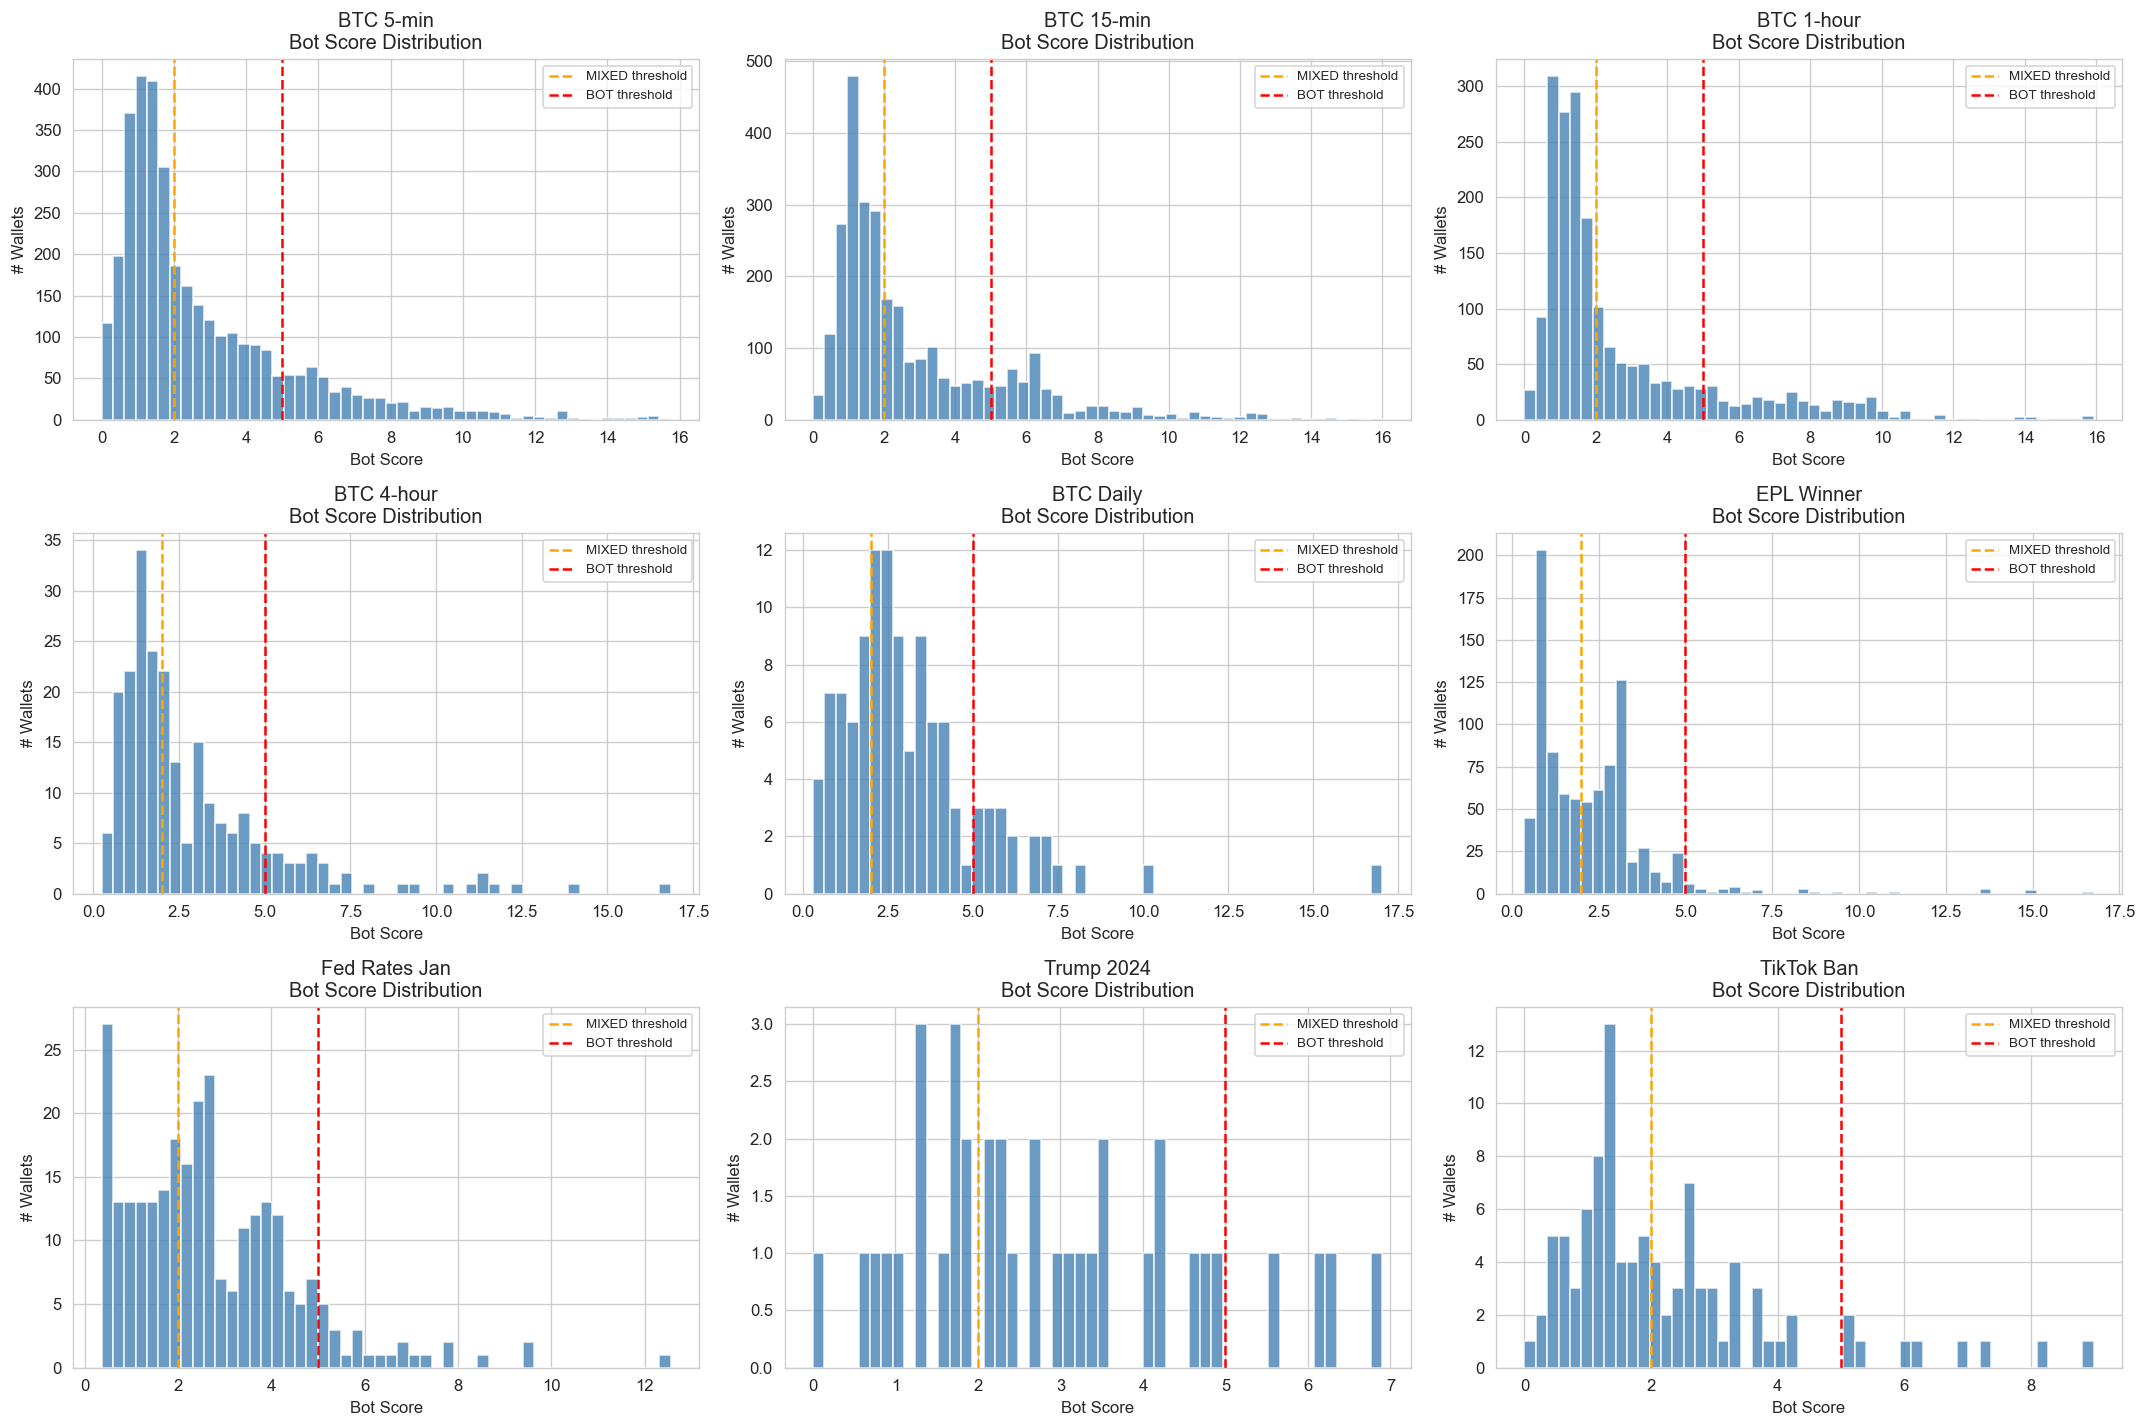

In [18]:
import math

n_groups = len(group_features)
ncols = 3
nrows = math.ceil(n_groups / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows))
axes = axes.flatten()

for i, (gname, fdf) in enumerate(group_features.items()):
    ax = axes[i]
    ax.hist(fdf['bot_score'], bins=50, color='steelblue', edgecolor='white', alpha=0.8)
    ax.axvline(2.0, color='orange', ls='--', label='MIXED threshold')
    ax.axvline(5.0, color='red', ls='--', label='BOT threshold')
    ax.set_title(f'{GROUP_LABELS[gname]}\nBot Score Distribution')
    ax.set_xlabel('Bot Score')
    ax.set_ylabel('# Wallets')
    ax.legend(fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## 3. Isolation Forest

Unsupervised anomaly detection over all 20 features. Catches multi-dimensional outlier patterns that rule-based scoring may miss.

- **200 trees**, `contamination=0.1` (top 10% flagged as anomalies)
- Outputs `if_anomaly` (-1 = anomaly, 1 = normal) and `if_score` (higher = more anomalous)

In [19]:
for gname, fdf in group_features.items():
    group_features[gname] = run_isolation_forest(fdf, contamination=0.1)
    n_anom = (fdf['if_anomaly'] == -1).sum()
    print(f'[{GROUP_LABELS[gname]}] IF anomalies: {n_anom} ({n_anom/len(fdf)*100:.1f}%)')

[BTC 5-min] IF anomalies: 351 (10.0%)
[BTC 15-min] IF anomalies: 287 (10.0%)
[BTC 1-hour] IF anomalies: 195 (10.0%)
[BTC 4-hour] IF anomalies: 23 (10.0%)
[BTC Daily] IF anomalies: 12 (10.4%)
[EPL Winner] IF anomalies: 89 (10.0%)
[Fed Rates Jan] IF anomalies: 28 (10.2%)
[Trump 2024] IF anomalies: 4 (10.8%)
[TikTok Ban] IF anomalies: 10 (10.1%)


## 4. Combined Detection

Merge rule-based scoring with Isolation Forest:

```
final_bot = (score >= 5)                          # high-confidence bot
          OR (2 <= score < 5 AND IF anomaly)      # borderline + IF confirms
```

- **High score alone** → bot regardless of IF
- **Medium score + IF anomaly** → bot (IF catches what rules miss)
- **Low score** → human even if IF flags it (prevents false positives)

In [20]:
for gname, fdf in group_features.items():
    # final_bot: rule-based BOT OR (MIXED + IF anomaly)
    fdf['final_bot'] = (
        (fdf['bot_label'] == 'BOT')
        | ((fdf['bot_label'] == 'MIXED') & (fdf['if_anomaly'] == -1))
    )
    n_bot = fdf['final_bot'].sum()
    tdf = group_trades[gname]
    bot_wallets = set(fdf[fdf['final_bot']].index)
    trade_share = tdf['proxy_wallet'].isin(bot_wallets).mean()
    print(
        f'[{GROUP_LABELS[gname]}] Bots: {n_bot}/{len(fdf)}'
        f' ({n_bot / len(fdf) * 100:.1f}%)'
        f' | Trade share: {trade_share * 100:.1f}%'
    )

[BTC 5-min] Bots: 693/3505 (19.8%) | Trade share: 65.6%
[BTC 15-min] Bots: 642/2866 (22.4%) | Trade share: 69.2%
[BTC 1-hour] Bots: 338/1944 (17.4%) | Trade share: 71.0%
[BTC 4-hour] Bots: 43/231 (18.6%) | Trade share: 47.8%
[BTC Daily] Bots: 25/115 (21.7%) | Trade share: 64.8%
[EPL Winner] Bots: 68/887 (7.7%) | Trade share: 7.9%
[Fed Rates Jan] Bots: 39/275 (14.2%) | Trade share: 9.5%
[Trump 2024] Bots: 8/37 (21.6%) | Trade share: 3.0%
[TikTok Ban] Bots: 12/99 (12.1%) | Trade share: 7.4%


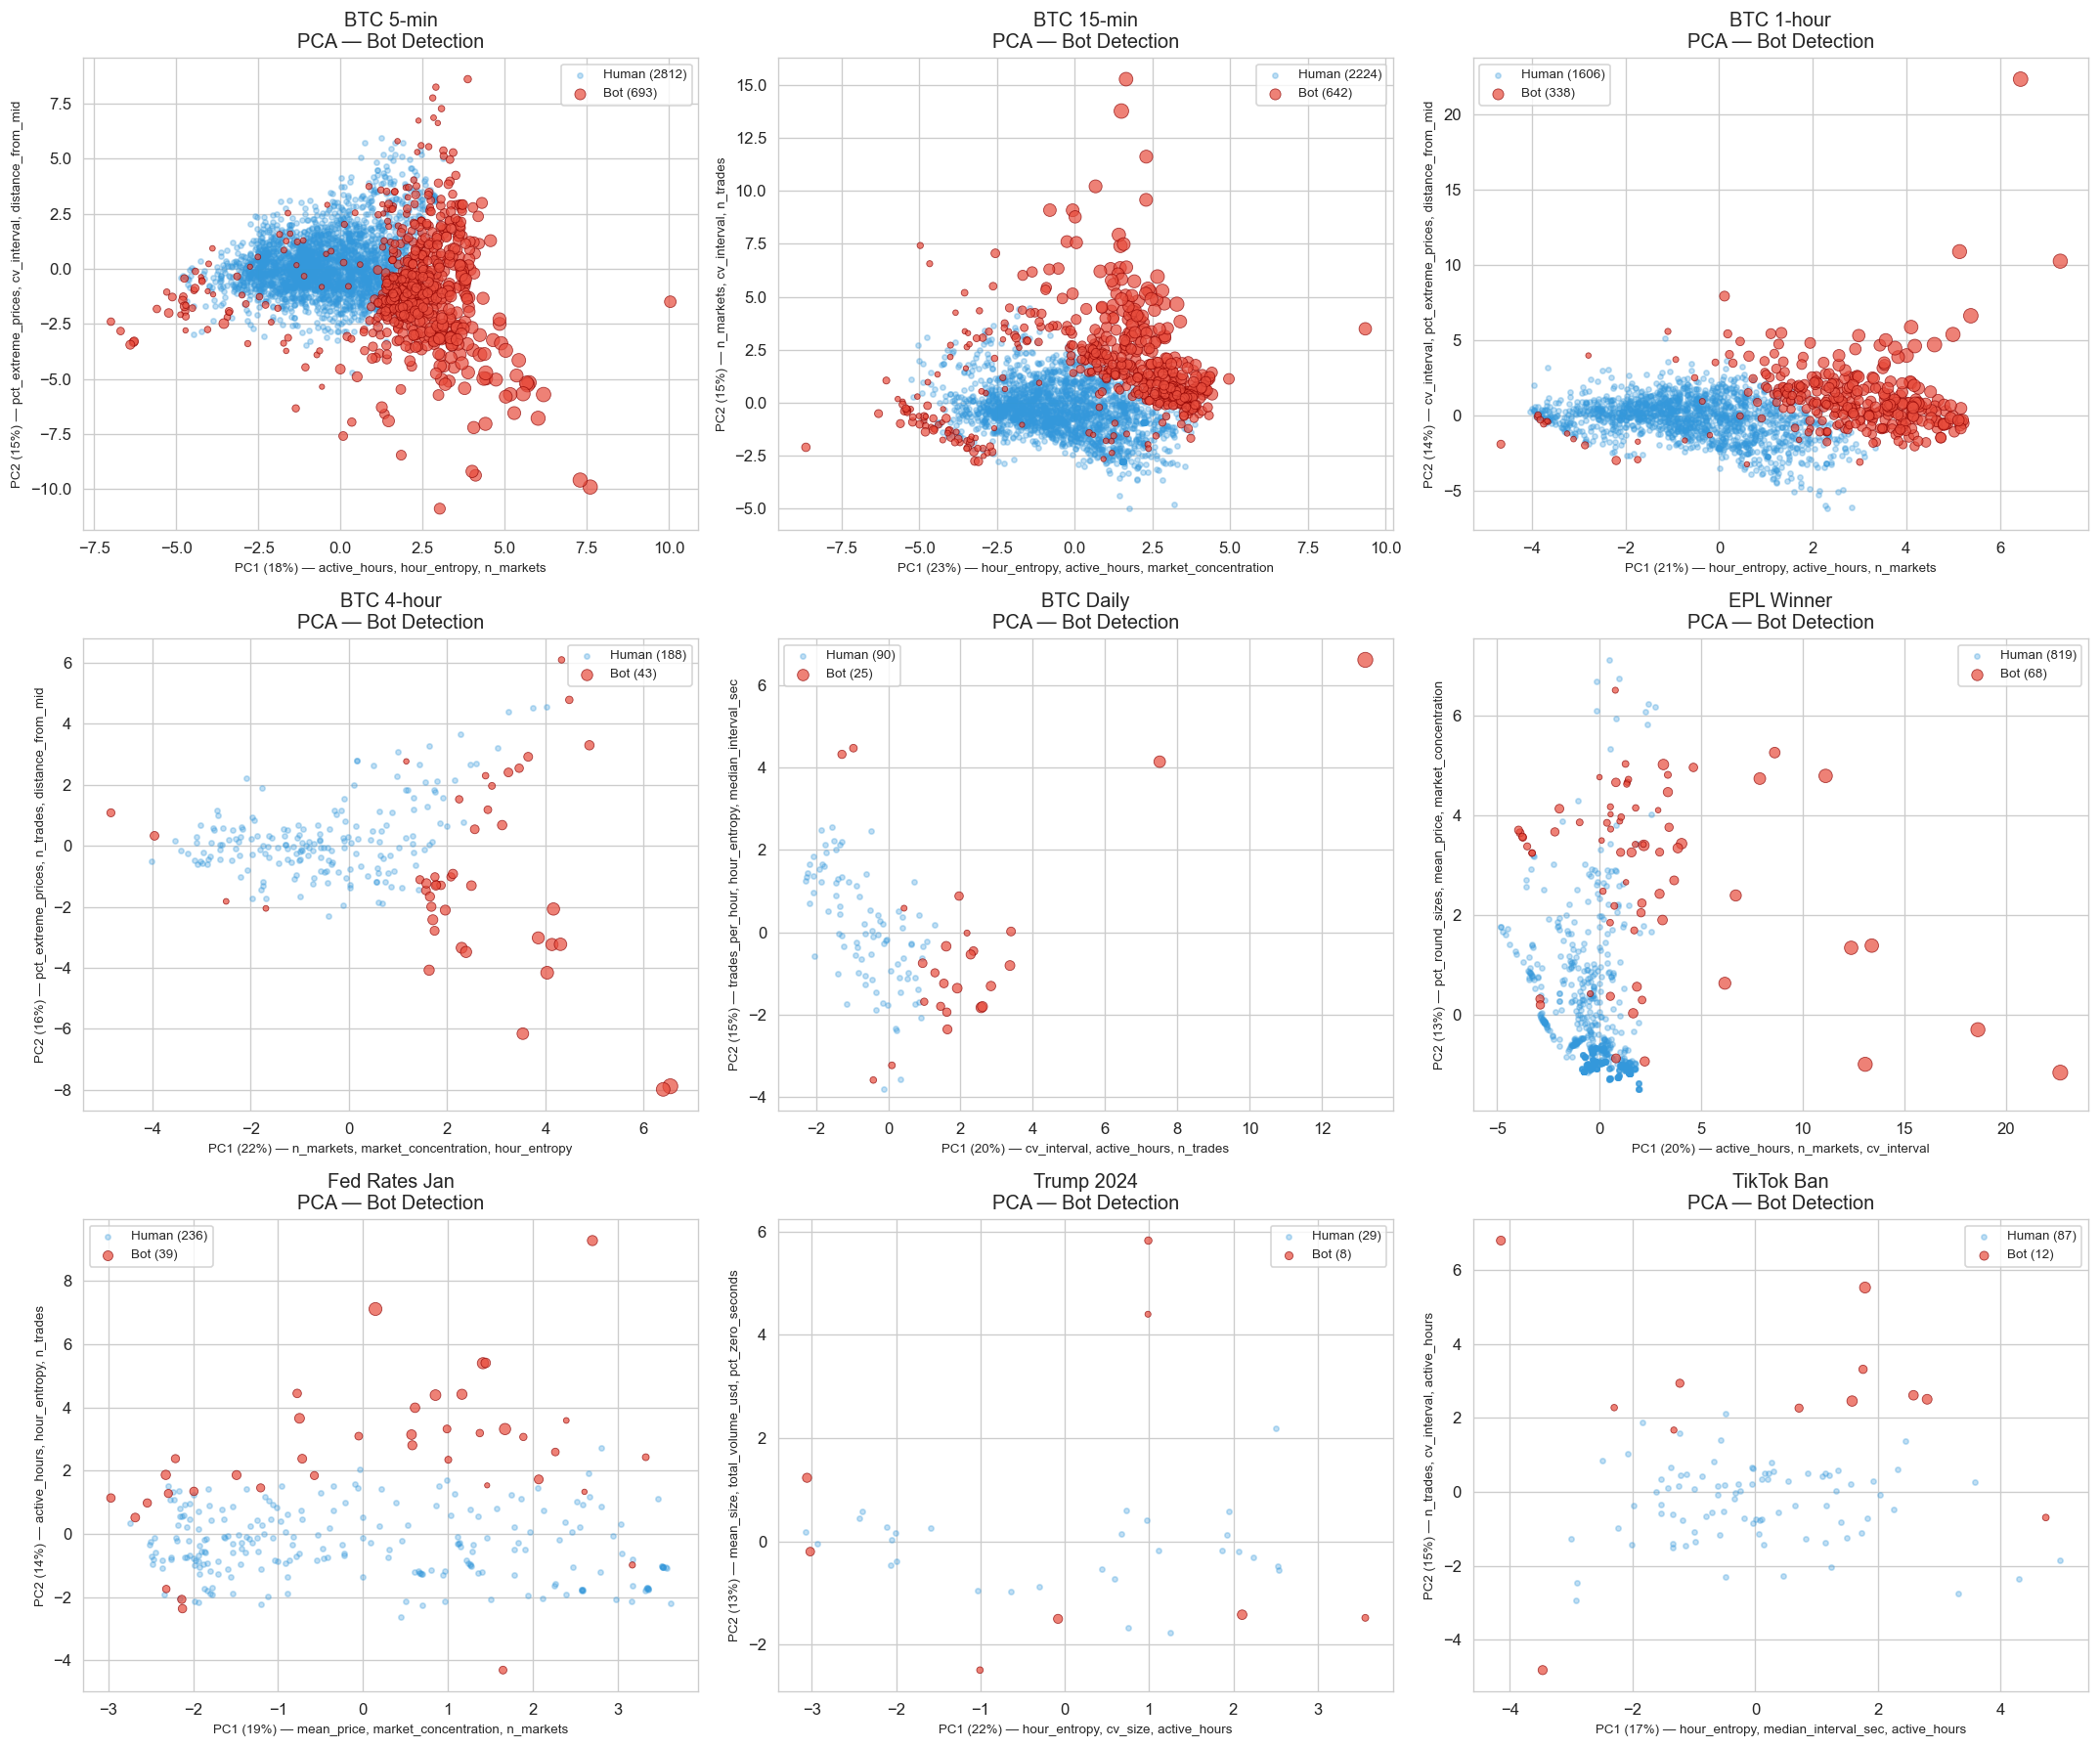

In [21]:
n_groups = len(group_features)
ncols = 3
nrows = math.ceil(n_groups / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows))
axes = axes.flatten()

for i, (gname, fdf) in enumerate(group_features.items()):
    ax = axes[i]
    cols = [c for c in FEATURE_COLS if c in fdf.columns]
    X = StandardScaler().fit_transform(fdf[cols].fillna(0))
    pca = PCA(n_components=2, random_state=42)
    coords = pca.fit_transform(X)

    def _top_loadings(comp_idx, n=3):
        loadings = pca.components_[comp_idx]
        top_idx = np.argsort(np.abs(loadings))[::-1][:n]
        return ', '.join(cols[j] for j in top_idx)

    ev = pca.explained_variance_ratio_
    pc1_label = f'PC1 ({ev[0] * 100:.0f}%) — {_top_loadings(0)}'
    pc2_label = f'PC2 ({ev[1] * 100:.0f}%) — {_top_loadings(1)}'

    humans = ~fdf['final_bot'].values
    bots = fdf['final_bot'].values

    ax.scatter(
        coords[humans, 0], coords[humans, 1],
        s=10, alpha=0.3, c='#3498db', label=f'Human ({humans.sum()})',
    )
    ax.scatter(
        coords[bots, 0], coords[bots, 1],
        s=fdf.loc[bots, 'bot_score'].clip(1, 20) * 5,
        alpha=0.7, c='#e74c3c', label=f'Bot ({bots.sum()})',
        edgecolors='darkred', linewidths=0.5,
    )
    ax.set_title(f'{GROUP_LABELS[gname]}\nPCA — Bot Detection')
    ax.set_xlabel(pc1_label, fontsize=8)
    ax.set_ylabel(pc2_label, fontsize=8)
    ax.legend(fontsize=8)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### What are PC1 and PC2?

**PCA (Principal Component Analysis)** reduces the 20-dimensional feature space into 2 axes for visualization.

- **PC1 (x-axis)**: The first principal component — the direction of maximum variance across all 20 features. In practice, PC1 typically captures the **overall activity scale**: wallets with high `n_trades`, `trades_per_hour`, `n_markets`, and `total_volume_usd` score high on PC1, while low-activity wallets score low. It separates heavy traders (bots) from casual participants (humans).

- **PC2 (y-axis)**: The second principal component — the direction of maximum remaining variance, orthogonal to PC1. PC2 often captures **behavioral style** differences: e.g., timing regularity (`cv_interval`, `hour_entropy`) vs. market concentration patterns. It distinguishes between *types* of bots or *types* of humans.

Together, PC1 and PC2 explain a significant fraction of total variance (check `pca.explained_variance_ratio_` for exact numbers). Points close together in PCA space have similar trading behavior across all 20 features; points far apart behave very differently.

## 5. Top Bots

Ranked by `bot_score`. Key columns:
- `n_trades` / `trades_per_hour` — activity level
- `n_markets` — breadth of participation
- `median_interval_sec` — speed between trades
- `cv_size` — order size consistency (low = fixed lots)
- `total_volume_usd` — total dollar volume

In [22]:
for gname, fdf in group_features.items():
    bots = fdf[fdf['final_bot']].sort_values('bot_score', ascending=False)
    if len(bots) == 0:
        print(f'[{GROUP_LABELS[gname]}] No bots detected')
        continue

    show_cols = [
        'bot_score', 'n_trades', 'trades_per_hour', 'n_markets',
        'median_interval_sec', 'cv_size', 'total_volume_usd',
    ]
    print(f'\n[{GROUP_LABELS[gname]}] Top 15 bots:')
    display(bots[show_cols].head(15))


[BTC 5-min] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0x0ea574f3204c5c9c0cdead90392ea0990f4d17e4,15.75,1240,299.436544,50,2.0,0.383074,24528.468947
0x1d0034134e339a309700ff2d34e99fa2d48b0313,15.42,1189,286.391008,50,2.0,0.561505,15410.291626
0x37c94ea1b44e01b18a1ce3ab6f8002bd6b9d7e6d,15.41,1874,452.535551,42,2.0,1.263828,72503.398050
0x6f6ee004b8a3814b7c4a5fbb59cd358a54d6e06c,15.32,2682,646.871231,49,0.0,0.085796,4668.972730
0x5924ca480d8b08cd5f3e5811fa378c4082475af6,15.18,1456,356.814159,42,0.0,1.772896,27032.048155
0x61276aba49117fd9299707d5d573652949d5c977,15.09,1132,273.319920,44,0.0,1.121234,24899.353849
0x1979ae6b7e6534de9c4539d0c205e582ca637c9d,14.98,1032,253.044544,50,2.0,0.903451,26912.369541
0xd0d6053c3c37e727402d84c14069780d360993aa,14.89,736,178.328173,43,2.0,0.267042,11545.997639
0x36ae97e6d0e5d3624a1ac070dce1f1b0c26d1a49,14.68,734,178.444084,50,2.0,0.328365,11229.062326



[BTC 15-min] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0xfeef3df249e3ba21a52c82abb770ca10fc64f1a1,16.00,4362,356.761178,50,2.0,4.625443,25655.100791
0x113d4c0b5a6702ab045ea2cba7c3f71d51fc3ce8,15.19,714,58.569931,48,4.0,0.440321,29549.867767
0x1d0034134e339a309700ff2d34e99fa2d48b0313,14.54,790,64.405091,49,4.0,1.142341,23914.307367
0x1979ae6b7e6534de9c4539d0c205e582ca637c9d,14.42,644,52.504756,50,4.0,1.557737,37842.684403
0xe00740bce98a594e26861838885ab310ec3b548c,14.31,1077,88.086150,50,4.0,0.703670,20356.469903
0x556788f38aec2b87d6c496ce738ebd8ec2c5a7b1,13.95,5707,468.320036,44,0.0,1.200226,7132.810522
0x688462bac091451841db3bf8c8d05360787de294,13.61,1408,116.954315,47,2.0,3.406521,11220.527007
0x6f6ee004b8a3814b7c4a5fbb59cd358a54d6e06c,13.56,1871,153.088777,44,2.0,0.058092,5096.240399
0x8e9cd5ec7a26d602b63b4bc4c193febb83c8ed64,13.44,398,32.722788,40,10.0,0.143517,18627.987178



[BTC 1-hour] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0x6031b6eed1c97e853c6e0f03ad3ce3529351f96d,15.92,2993,60.501314,50,4.0,0.300580,35609.635630
0x93b110ff31deb58847e841b3cbc6535b3e7b746e,15.89,29519,596.953117,40,0.0,2.086455,69618.512760
0x113d4c0b5a6702ab045ea2cba7c3f71d51fc3ce8,15.89,4394,88.846452,50,8.0,0.455627,91195.066450
0xf247584e41117bbbe4cc06e4d2c95741792a5216,15.32,2286,46.246179,50,16.0,0.848492,82385.081682
0x1979ae6b7e6534de9c4539d0c205e582ca637c9d,15.23,2905,58.760071,50,8.0,2.029808,287514.579262
0xd0d6053c3c37e727402d84c14069780d360993aa,14.88,5690,115.055382,38,4.0,0.530626,173834.239700
0x6b1bdf3c115b85083dd41feae4daf7a634531923,14.32,2418,48.914913,50,16.0,0.130678,14169.443767
0x19b3823092892c026517fd0ff58df4889abe0b9b,14.27,1251,25.303398,47,40.0,0.321392,41639.236130
0x4b188496d1b3da1716165380999afb9b314c725f,13.98,1340,27.169811,50,10.0,1.048118,48440.021286



[BTC 4-hour] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0x1979ae6b7e6534de9c4539d0c205e582ca637c9d,16.85,629,13.124978,12,83.0,3.597588,72876.810940
0x8888a4f8c8d3834482d77405530d7f5428a40b39,14.06,860,18.185663,12,2.0,0.783235,7824.752557
0x048d78cfb8fbdc209c0e9529b525bc150a3668da,12.30,219,4.689396,11,27.0,0.889337,4256.102412
0xf96d0c78a9747f86e2cb0aed4ee701d0f637df3e,11.81,91,1.920934,11,327.0,0.321930,259.532775
0xf3d256b221fd75f89a993fefd1e813ad4ddee351,11.46,82,1.848674,12,394.0,0.332078,93.057791
0xed86741e5223f1b72945f6c4002168b2588e78c7,11.31,111,2.442065,11,272.0,1.234871,2817.014764
0x1ae9558b150104c62606956ebe2ae6bc2ee8e9f3,10.98,80,1.866542,10,576.0,0.760957,158.443499
0x257d0d66330654577734650715f5c46b540e3a03,10.21,72,1.926336,7,134.0,0.634086,251006.835090
0x7eff990ab94f4531b36ac0b3ec51310943dac9a7,9.50,124,2.967217,9,50.0,1.809654,126.500413



[BTC Daily] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0xa42f127d7e8df9f16881ffcc9ed0bc0326875f5a,17.03,2347,108.934788,2,2.0,1.955572,44455.602722
0x1461cc6e1a05e20710c416307db62c28f1d122d8,10.07,545,23.411212,2,2.0,2.993753,57102.045704
0x0070b32fbd894ad5447c6629d2c64b9b02410414,8.16,36,1.606744,2,368.0,0.586614,1348.750750
0xf77bb14812cd1ef8dfe3cf82821ec7e2478142e9,7.62,31,1.388889,2,449.0,0.710551,919.240720
0x8eac7e280c27d0a5ec8ee18b7294b404f6c2db7a,7.26,54,2.455786,2,28.0,2.317342,3948.799000
0xb4f7ca9a53960a17cb9f5a86ec880ff611dadab8,7.05,36,1.610498,2,226.0,1.518224,32.334005
0x997cda7b31612e3c394bfb55440619f3f689251e,6.93,197,19.040971,1,51.0,1.081707,2629.637936
0x82019b5de2897eda53a67abd5cf933df4da85d39,6.75,15,0.666584,2,360.0,1.151979,14592.117709
0xe5f85d076f0b1edd4ec89bfb95e123a9036a8d75,6.31,41,1.821952,2,15.0,0.669498,20013.775380



[EPL Winner] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0xd218e474776403a330142299f7796e8ba32eb5c9,16.76,1530,0.827461,16,2.0,2.516910,255721.146410
0x63d43bbb87f85af03b8f2f9e2fad7b54334fa2f1,15.01,229,0.111850,19,2.0,2.720090,58082.537779
0xe8dd7741ccb12350957ec71e9ee332e0d1e6ec86,14.95,1229,0.916762,15,2.0,3.024403,64018.764447
0xe3726a1b9c6ba2f06585d1c9e01d00afaedaeb38,13.76,257,0.140816,17,0.0,1.069953,41.734470
0x00e2d8f88b39d9b430c136c679369f41101cd56a,13.65,49,0.035814,8,4621.0,2.803313,952470.996850
0x7298060b1844a4c4ca0578146ab3f5e76aa1fcfc,13.57,317,0.216038,12,0.0,1.303277,81.910501
0x640b4d1b4772d8c6d1dc324f74c1df906b1a2ed0,10.92,104,0.098836,3,204.0,0.820940,160728.229469
0x07e78f5f58f8fa839f298cfe3fefd258883aa343,10.35,31,0.013547,7,12701.5,3.695622,57844.432540
0x55b4af6a1cff148a307cad8ad098206a028e80ea,9.45,32,0.017111,7,74.0,3.236077,587.849070



[Fed Rates Jan] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0x241f846866c2de4fb67cdb0ca6b963d85e56ef50,12.56,85,3.649896,2,37.0,0.291352,1.647893e+06
0x0a371f1edf28cbe6ed5b798a038345a8bf047cd4,9.59,52,8.902416,2,96.0,0.007379,8.768841e+05
0xc31816aaca2a9a9ef0eaa7192b314deae86b7c13,9.44,40,1.465261,2,172.0,0.007655,2.460645e+03
0x30cc79b0acff35d82194aa81a2b067e026c352fc,8.62,23,0.605268,3,432.0,0.624704,5.232087e+01
0x4d59652f8c3b4cb2aee44a54adbeb59fb3631e2f,7.78,235,34.467305,1,22.0,2.538960,2.913293e+02
0x1e80d8ad0058623ffb2b8a7e8c05228323725efb,7.76,56,1.203280,2,152.0,0.008567,3.115112e+03
0xf0ec554fe75d57fef3f2404fce070b5c71d46064,7.25,14,0.383442,3,6440.0,1.527225,1.732392e+03
0x87c0540bc97f4377f86dd915e1c279621e726660,7.09,45,1.226056,3,10.0,0.000802,4.904507e+01
0xd5243dc06a3dbdfcb8a3b5acf455d4382e050f5a,6.87,96,12.314709,2,74.0,2.456302,3.187999e+01



[Trump 2024] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0x08f059c7e5e73f433151bd73f2394fc249f04ca4,6.90,13,5.395435,1,75.0,0.897204,3.832439e+04
0x7caeeadf0421f75e60945a839b8716080891fb5c,6.28,9,952.941176,1,4.0,0.123837,8.610260e+05
0x06d8c2bbcb569b210aeab31cad9be928f11c2a12,6.21,19,12.084806,1,128.0,0.520040,2.631498e+04
0xe92772e4e8e61508f9a5ecc2fda94118a45bb066,5.64,18,263.414634,1,10.0,0.001708,3.238189e+03
0xe9ad918c7678cd38b12603a762e638a5d1ee7091,4.10,5,11.597938,1,115.0,0.606056,4.169219e+06
0x23728cd9f76029bc1e9d0dcb8e27ed0f57188881,3.52,5,3.660769,1,1109.0,1.596200,1.710426e+02
0x4447034f24f4a2e59efdbcf9e6dc26aa6d354f5a,3.25,15,33.415842,1,12.0,1.598653,1.696508e+02
0x4fee3c6ea1e1d727a7a2ea2b7070e7ec70cfa7e7,2.69,5,7.643312,1,422.0,0.781518,2.706582e+06



[TikTok Ban] Top 15 bots:


,bot_score,n_trades,trades_per_hour,n_markets,median_interval_sec,cv_size,total_volume_usd
proxy_wallet,,,,,,,
0x88d0bc2559aa66fa6b8a16e0b08f2e3946c3c51f,8.99,54,5.264156,1,314.0,1.770578,1.050000e+02
0x48185887c8dc95de60ee89722f1d0ee7894cbf0b,8.14,25,2.489007,1,539.0,0.762637,7.462660e+04
0x4aa1d8b93a2544f69d8c619d6b7e75bf305a13bd,7.23,18,1.789511,1,1619.0,0.963571,2.000700e+02
0x4eb85167e92a59b671478bbdaaa901551a6a9231,6.88,16,1.647267,1,848.0,1.084794,1.603531e+03
0x4fa3b8fe727fff57f6278caccb3598cca4380a68,6.21,5,89.108911,1,55.0,0.001248,1.517718e+03
0xc4439174a5d5f821e173ce86def1d86c3145f19f,6.04,20,2.868983,1,44.0,1.419746,2.256617e+06
0x24c8cf69a0e0a17eee21f69d29752bfa32e823e1,5.25,11,1.060837,1,781.0,2.111270,2.302112e+04
0x42a6ddf7cf7032972b0bfe32775e8109c5171b64,5.06,24,3.062527,1,100.0,1.101530,2.656308e+05
0x20235f3a9382e947b1b09daf4d142b53d5462d55,5.04,14,1.313150,1,66.0,1.301892,1.474611e+03


## 6. Bot vs Human Feature Comparison

Side-by-side comparison of mean feature values between detected bots and non-bots. The `Bot/Human ratio` column shows how many times larger (or smaller) the bot average is.

In [23]:
compare_cols = [
    'n_trades', 'trades_per_hour', 'n_markets', 'median_interval_sec',
    'cv_size', 'active_hours', 'total_volume_usd', 'market_concentration',
]

for gname, fdf in group_features.items():
    bots = fdf[fdf['final_bot']]
    humans = fdf[~fdf['final_bot']]
    if len(bots) == 0:
        continue

    human_mean = humans[compare_cols].mean().replace(0, np.nan)
    comp = pd.DataFrame({
        'Bot (mean)': bots[compare_cols].mean(),
        'Human (mean)': humans[compare_cols].mean(),
        'Bot/Human ratio': bots[compare_cols].mean() / human_mean,
    }).round(2)
    print(f'\n[{GROUP_LABELS[gname]}] Bot({len(bots)}) vs Human({len(humans)}):')
    display(comp)


[BTC 5-min] Bot(693) vs Human(2812):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,139.66,15.86,8.80
trades_per_hour,164.26,15.48,10.61
n_markets,23.22,8.26,2.81
median_interval_sec,275.30,317.50,0.87
cv_size,0.80,0.80,1.00
active_hours,4.31,2.49,1.73
total_volume_usd,2060.73,243.84,8.45
market_concentration,0.12,0.20,0.62



[BTC 15-min] Bot(642) vs Human(2224):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,161.66,18.17,8.90
trades_per_hour,172.53,6.90,25.02
n_markets,22.80,7.31,3.12
median_interval_sec,689.16,1293.31,0.53
cv_size,0.80,0.68,1.18
active_hours,9.86,4.60,2.14
total_volume_usd,2779.62,325.12,8.55
market_concentration,0.15,0.24,0.65



[BTC 1-hour] Bot(338) vs Human(1606):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,312.38,24.17,12.92
trades_per_hour,116.64,7.29,15.99
n_markets,27.29,6.24,4.37
median_interval_sec,1757.08,3052.26,0.58
cv_size,0.85,0.84,1.02
active_hours,18.36,5.89,3.12
total_volume_usd,7871.70,526.80,14.94
market_concentration,0.10,0.33,0.30



[BTC 4-hour] Bot(43) vs Human(188):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,78.58,12.37,6.35
trades_per_hour,18.38,6.26,2.94
n_markets,7.49,2.95,2.54
median_interval_sec,5084.37,2954.58,1.72
cv_size,0.81,0.76,1.07
active_hours,10.16,3.97,2.56
total_volume_usd,9925.00,284.65,34.87
market_concentration,0.24,0.54,0.44



[BTC Daily] Bot(25) vs Human(90):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,155.44,11.13,13.96
trades_per_hour,17.81,9.72,1.83
n_markets,1.72,1.43,1.20
median_interval_sec,962.36,898.00,1.07
cv_size,1.18,0.80,1.47
active_hours,6.84,2.68,2.55
total_volume_usd,7329.97,360.92,20.31
market_concentration,0.71,0.86,0.82



[EPL Winner] Bot(68) vs Human(819):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,66.01,8.15,8.10
trades_per_hour,42.50,13.73,3.09
n_markets,4.06,2.95,1.37
median_interval_sec,63142.90,18545.34,3.40
cv_size,0.95,0.57,1.67
active_hours,7.62,2.67,2.85
total_volume_usd,54618.71,1420.79,38.44
market_concentration,0.52,0.42,1.26



[Fed Rates Jan] Bot(39) vs Human(236):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,29.31,7.94,3.69
trades_per_hour,85.79,18.10,4.74
n_markets,2.54,2.30,1.10
median_interval_sec,2712.27,2009.94,1.35
cv_size,1.11,0.73,1.52
active_hours,5.15,2.70,1.91
total_volume_usd,222232.16,9544.57,23.28
market_concentration,0.57,0.60,0.96



[Trump 2024] Bot(8) vs Human(29):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,11.12,7.55,1.47
trades_per_hour,161.27,84.69,1.90
n_markets,1.00,1.00,1.00
median_interval_sec,234.38,197.17,1.19
cv_size,0.77,0.65,1.17
active_hours,2.12,1.62,1.31
total_volume_usd,975630.63,163385.86,5.97
market_concentration,1.00,1.00,1.00



[TikTok Ban] Bot(12) vs Human(87):


,Bot (mean),Human (mean),Bot/Human ratio
n_trades,18.42,6.93,2.66
trades_per_hour,9.73,4.34,2.24
n_markets,1.00,1.00,1.00
median_interval_sec,808.58,1341.91,0.60
cv_size,1.15,0.94,1.22
active_hours,5.50,3.09,1.78
total_volume_usd,227108.58,5671.41,40.04
market_concentration,1.00,1.00,1.00


## 7. Cross-Group Analysis

Check which bot wallets appear across multiple market groups. Cross-market bots suggest systematic operators running the same infrastructure across different market types.

In [24]:
bot_sets = {
    g: set(fdf[fdf['final_bot']].index) for g, fdf in group_features.items()
}

print('Bot counts per group:')
for g, bs in bot_sets.items():
    tdf = group_trades[g]
    ts = tdf['proxy_wallet'].isin(bs).mean() * 100
    print(f'  {GROUP_LABELS[g]:15s}: {len(bs):4d} bots | {ts:.1f}% of trades')

gl = list(bot_sets.keys())
print('\nOverlap:')
for i, g1 in enumerate(gl):
    for g2 in gl[i+1:]:
        overlap = bot_sets[g1] & bot_sets[g2]
        print(f'  {GROUP_LABELS[g1]} ∩ {GROUP_LABELS[g2]}: {len(overlap)}')

if len(gl) >= 2:
    all_bots = set.union(*bot_sets.values())
    wallet_groups = defaultdict(set)
    for g, ws in bot_sets.items():
        for w in ws:
            wallet_groups[w].add(g)
    cross = {w: gs for w, gs in wallet_groups.items() if len(gs) >= 2}
    print(f'\nTotal unique bots: {len(all_bots)}')
    print(f'Cross-market bots (2+ groups): {len(cross)}')
    if cross:
        for w, gs in sorted(cross.items(), key=lambda x: -len(x[1]))[:10]:
            print(f'  {w[:16]}... in {len(gs)} groups: {", ".join(GROUP_LABELS[g] for g in gs)}')

Bot counts per group:
  BTC 5-min      :  693 bots | 65.6% of trades
  BTC 15-min     :  642 bots | 69.2% of trades
  BTC 1-hour     :  338 bots | 71.0% of trades
  BTC 4-hour     :   43 bots | 47.8% of trades
  BTC Daily      :   25 bots | 64.8% of trades
  EPL Winner     :   68 bots | 7.9% of trades
  Fed Rates Jan  :   39 bots | 9.5% of trades
  Trump 2024     :    8 bots | 3.0% of trades
  TikTok Ban     :   12 bots | 7.4% of trades

Overlap:
  BTC 5-min ∩ BTC 15-min: 78
  BTC 5-min ∩ BTC 1-hour: 33
  BTC 5-min ∩ BTC 4-hour: 11
  BTC 5-min ∩ BTC Daily: 1
  BTC 5-min ∩ EPL Winner: 0
  BTC 5-min ∩ Fed Rates Jan: 0
  BTC 5-min ∩ Trump 2024: 0
  BTC 5-min ∩ TikTok Ban: 0
  BTC 15-min ∩ BTC 1-hour: 38
  BTC 15-min ∩ BTC 4-hour: 9
  BTC 15-min ∩ BTC Daily: 1
  BTC 15-min ∩ EPL Winner: 0
  BTC 15-min ∩ Fed Rates Jan: 0
  BTC 15-min ∩ Trump 2024: 0
  BTC 15-min ∩ TikTok Ban: 0
  BTC 1-hour ∩ BTC 4-hour: 16
  BTC 1-hour ∩ BTC Daily: 2
  BTC 1-hour ∩ EPL Winner: 0
  BTC 1-hour ∩ Fed Rates Ja

## 8. Summary

| Metric | Description |
|--------|-------------|
| **Wallets** | Total wallets with >= 5 trades |
| **Bots** | Wallets flagged as `final_bot` |
| **Bot%** | Bot wallet ratio |
| **TrdShare** | Fraction of all trades made by bots |
| **AvgScore** | Mean bot_score among detected bots |

In [25]:
print('=' * 70)
print('Bot Detection — Final Summary')
print('=' * 70)
header = f"{'Group':<15} {'Wallets':>8} {'Bots':>6} {'Bot%':>7} {'TrdShare':>9} {'AvgScore':>9}"
print(f"\n{header}")
print('-' * 55)

for gname, fdf in group_features.items():
    tdf = group_trades[gname]
    bots = fdf[fdf['final_bot']]
    bot_wallets = set(bots.index)
    ts = tdf['proxy_wallet'].isin(bot_wallets).mean() * 100
    avg_sc = bots['bot_score'].mean() if len(bots) > 0 else 0
    bot_pct = len(bots) / len(fdf) * 100
    print(
        f"{GROUP_LABELS[gname]:<15} {len(fdf):>8} {len(bots):>6}"
        f" {bot_pct:>6.1f}% {ts:>8.1f}% {avg_sc:>9.1f}"
    )

print('-' * 55)
print('\nDetection method: z-score rule-based + Isolation Forest')
print('Bot = (score >= 5) OR (score >= 2 AND IF anomaly)')
print('Done.')

Bot Detection — Final Summary

Group            Wallets   Bots    Bot%  TrdShare  AvgScore
-------------------------------------------------------
BTC 5-min           3505    693   19.8%     65.6%       6.7
BTC 15-min          2866    642   22.4%     69.2%       6.5
BTC 1-hour          1944    338   17.4%     71.0%       7.4
BTC 4-hour           231     43   18.6%     47.8%       6.9
BTC Daily            115     25   21.7%     64.8%       6.1
EPL Winner           887     68    7.7%      7.9%       5.7
Fed Rates Jan        275     39   14.2%      9.5%       5.6
Trump 2024            37      8   21.6%      3.0%       4.8
TikTok Ban            99     12   12.1%      7.4%       5.7
-------------------------------------------------------

Detection method: z-score rule-based + Isolation Forest
Bot = (score >= 5) OR (score >= 2 AND IF anomaly)
Done.
